### Data preprocessing

- spatial domain: global land
- temporal domain: 1950-01-01 - 2014-12-31

| var  | dims | path |
| ---  | ---  | ---  |
| **input vars** |
| Rainf  | lat, lon, time (per year) | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/Rainf/' |
| Snowf  | lat, lon, time (per year) | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/Snowf/' |
| SWdown  | lat, lon, time (per year) | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/SWdown/' |
| LWdown  | lat, lon, time (per year) | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/LWdown/' |
| Tair  | lat, lon, time (per year) | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/Tair/' |
| Wind  | lat, lon, time (per year) | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/Wind/' |
| Qair  | lat, lon, time (per year) | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/Qair/' |
| PSurf  | lat, lon, time | '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/PSurf/' |
| lai | lat, lon, time | '/workspace/BGI/work_3/dl_chapter14/input_data/org_data/matsiro-gw_lai.nc' |
| ccover | lat, lon, time | '/workspace/BGI/work_3/dl_chapter14/input_data/org_data/matsiro-gw_ccover.nc' |
| PFT | lat, lon | '/workspace/BGI/work_3/dl_chapter14/input_data/org_data/matsiro-gw_PFT.nc' |
| soil_properties | lat, lon | '/workspace/BGI/work_3/dl_chapter14/input_data/org_data/matsiro-gw_soil_propreties.nc' |
| **target vars**
| et (also input) | lat, lon, time (per year) | '/workspace/BGI/people/skoirala/spmip/full_matsiro-gw_exp3.run1_20180805_latlonReverse/full_matsiro-gw_exp3_experiment_3_YYYY.nc' |
| mrlslfrac (mean of first 4 levels)  | lat, lon, time (per year) | '/workspace/BGI/people/skoirala/spmip/full_matsiro-gw_exp3.run1_20180805_latlonReverse/full_matsiro-gw_exp3_experiment_3_YYYY.nc' |
| tws  | lat, lon, time (per year) | '/workspace/BGI/people/skoirala/spmip/full_matsiro-gw_exp3.run1_20180805_latlonReverse/full_matsiro-gw_exp3_experiment_3_YYYY.nc' |
| mrro  | lat, lon, time  (per year) | '/workspace/BGI/people/skoirala/spmip/full_matsiro-gw_exp3.run1_20180805_latlonReverse/full_matsiro-gw_exp3_experiment_3_YYYY.nc' |


The datasets are first harmonized and copyed to local storage in NetCDF format, then, all datasets are combined into one zarr file, update data attributes.

In [6]:
import xarray as xr
import zarr
from dask.diagnostics import ProgressBar
import numpy as np
import sys
import os
import shutil
import ray

sys.path.append('/workspace/bkraft/dl_chapter14/src')
from utils.plotting import plot_map, subplots_robinson, plot_scatter, plot_hist2d, plot_hexbin
from utils.parallel import parcall

# Configuration

In [7]:
data_store = '/scratch/dl_chapter14/data/'
netcdf_store = os.path.join(data_store, 'netcdf')
zarr_store = os.path.join(data_store, 'data.zarr')
years = np.arange(1950, 2014+1)

if not os.path.isdir(netcdf_store):
    os.makedirs(netcdf_store)

# Functions

In [8]:
def harmonize_ds(ds):
    """Select proper date range and calculate mean of leveled datasets.
    
    * Renames 'longitude' and 'latitude' for 'lon' and 'lat'

    Parameters
    ----------
    ds:    xr.Dataset

    """
    
    if 'latitude' in ds:
        ds = ds.rename(latitude='lat')
    if 'longitude' in ds:
        ds = ds.rename(longitude='lon')
    if 'soil_propreties' in ds:
        ds = ds.rename(soil_propreties='soil_properties')

    varnames = ds.data_vars
    ds = ds.rename({var: var.lower() for var in varnames})

    if ds.lat[0] < ds.lat[1]:
        ds = ds.reindex(lat=list(reversed(ds.lat)))

    return ds

def chunk_ds(ds):
    chunks = {'lat': 10, 'lon': 10}
    if 'time' in ds:
        chunks.update({'time': -1})
    ds = ds.chunk(chunks)
    return ds

def get_encoding(ds):
    return {var: {'compressor': None} for var in ds.data_vars}

def zarr_rm_array(store, var):
    store = zarr.open(zarr_store, mode='r+')
    if var in store:
        store.store.rmdir(var)

def stack_time(files_in, var, zarr_store, mode='a'):
    """Stack multiple datasets along time dimension.

    Parameters
    ----------
    files_in        List of netcdf file paths.
    zarr_store      Zarr store to append the array to.
    mode            'w' to create a new group, 'a' to append (default).

    """

    zarr_rm_array(zarr_store, var.lower())
    ds = xr.open_mfdataset(
        files_in, parallel=True, preprocess=harmonize_ds,
        combine='by_coords')
    ds = chunk_ds(ds)
    ds.to_zarr(zarr_store, mode=mode, encoding=get_encoding(ds))

def matsiro_preproc(ds, var):
    """Select proper date range and calculate mean of leveled datasets.
    
    * Removes the 366th date from non-leap-years, as this is encoded as
      next year's 1st of January.
    * For the variable 'mrlslfrac', the mean of the first 4 layers
      is calculated.

    Parameters
    ----------
    ds:    xr.Dataset
    var:   str, variable to elect

    """
    year = ds.time.values[0].astype('datetime64[Y]').astype(int) + 1970
    data_slice = slice(f'{year}-01-01', f'{year}-12-31')
    
    if var == 'mrlslfrac':
        ds[var] = ds[var].isel(levelc=[0, 1, 2, 3]).mean('levelc')
    
    ds = ds[[var]].sel(time=data_slice)
    ds = harmonize_ds(ds)
    
    return ds

def combine_matsiro(files_in, file_out, var, mode='a'):
    zarr_rm_array(zarr_store, var)
    ds = xr.open_mfdataset(files_in, preprocess=lambda x: matsiro_preproc(x, var), parallel=True, combine='by_coords')
    ds = chunk_ds(ds)
    ds.to_zarr(zarr_store, mode=mode, encoding=get_encoding(ds))

# MATSIRO inputs

Other model inputs not contained in GSWP3

#### Processing steps

Copy to local storage

In [30]:
basedir = '/workspace/BGI/work_3/dl_chapter14/input_data/org_data/'
varnames = ['lai', 'ccover', 'PFT', 'soil_propreties']
files = {
    var: os.path.join(basedir, f'matsiro-gw_{var}.nc') for var in varnames
}

In [11]:
# Create the zarr store by writing a first file.
lai = files.pop('lai')

ds = xr.open_dataset(lai)
ds = harmonize_ds(ds)
ds = chunk_ds(ds)

with ProgressBar():
    ds.to_zarr(zarr_store, mode='w', encoding=get_encoding(ds))

# Create zarr using first dataset.


[########################################] | 100% Completed | 12min 17.6s


In [12]:
# For all further datasets, we append to the existing zarr store.
for i, (k, v) in enumerate(files.items()):
    print(f'{i+1:2d} / {len(files)}')
    ds = xr.open_dataset(v)
    ds = harmonize_ds(ds)
    ds = chunk_ds(ds)

    zarr_rm_array(zarr_store, k)
    
    with ProgressBar():
        ds.to_zarr(zarr_store, mode='a', encoding=get_encoding(ds))

 1 / 3
[########################################] | 100% Completed | 13min 59.5s
 2 / 3
[########################################] | 100% Completed |  5.2s
 3 / 3
[########################################] | 100% Completed |  5.1s


# MATSIRO outputs

#### processing steps

Extract from multi-varaible NetCDF file, stack time, harmonize data (non-leap years have empty last time-step each year) and copy to local storage. For the variable *mrlslfrac*, calculate mean of top four layers.

In [111]:
varnames = ['et', 'mrro', 'tws', 'mrlslfrac']

In [112]:
matsiro_paths = {
    var: {
        'files_in': [
            f'/workspace/BGI/people/skoirala/spmip/full_matsiro-gw_exp3.run1_20180805_latlonReverse/full_matsiro-gw_exp3_experiment_3_{y}.nc'
            for y in years],
        'file_out': os.path.join(netcdf_store, f'{var}.nc'),
        'var': var
    } for var in varnames
}

In [23]:
parcall(combine_matsiro, matsiro_paths, num_cpus=4, ray_init_kwargs={'object_store_memory': 100e9}, mode='a')

2019-12-01 12:01:02,259	INFO resource_spec.py:205 -- Starting Ray with 335.01 GiB memory available for workers and up to 93.13 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


2019-12-01 12:01:02 - Parallel execution of function `combine_matsiro` using 4 CPUs with 4 total runs.
(pid=12442) /opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
(pid=12442)   x = np.divide(x1, x2, out)
2019-12-01 12:19:13 - Done, elapsed time: 18 m 11 s (4 m 32 s per call).


[None, None, None, None]

# GSWP3

http://hydro.iis.u-tokyo.ac.jp/GSWP3/

#### Processing steps

Stack data and copy to local disc to improve speed of further processing steps

In [117]:
gswp_dir = '/workspace/BGI/data/DataStructureMDI/DATA/grid/Global/0d50_daily/GSWP3/EXP1/Data/'
# gswp_vars = ['Rainf', 'Snowf', 'SWdown', 'LWdown', 'Tair', 'Wind', 'Qair', 'PSurf']
gswp_vars = ['SWdown', 'LWdown', 'Qair', 'PSurf']

#### Stack data and copy to local disc

In [118]:
gswp_paths = {}
for var in gswp_vars:
    gswp_paths.update({
        var: {
            'files_in': [os.path.join(gswp_dir, var, f'{var}.{y}.nc') for y in years],
            'var': var
        }
    })

In [ ]:
# Stack years and copy to local storage. This takes some hours to run!
parcall(stack_time, gswp_paths, num_cpus=1, zarr_store=zarr_store, ray_init_kwargs={'memory': 500e9, 'object_store_memory': 250e9})

2019-12-01 15:44:43,485	INFO resource_spec.py:205 -- Starting Ray with 465.62 GiB memory available for workers and up to 232.83 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


2019-12-01 15:44:43 - Parallel execution of function `stack_time` using 1 CPUs with 4 total runs.
(pid=19773) /opt/conda/lib/python3.6/site-packages/xarray/core/dataset.py:1616: SerializationWarning: saving variable None with floating point data as an integer dtype without any _FillValue to use for NaNs
(pid=19773)   append_dim=append_dim,


# Fix coordinates (shifted)

In [137]:
s_zr = zarr.open(zarr_store, mode='r+')

In [136]:
s_zr.lat[:] = xr.open_dataset(gswp_paths['SWdown']['files_in'][0]).latitude.values
s_zr.lon[:] = xr.open_dataset(gswp_paths['SWdown']['files_in'][0]).longitude.values

# Add attributes do zarr

* Add global attributes
* Add missing long_name and unit attribute if missing
* Add mean and std as attribute

In [247]:
s_xr = xr.open_zarr(zarr_store)
s_zr = zarr.open(zarr_store, 'r+')

In [248]:
global_attrs = {
    'processed_by': 'bkraft@bgc-jena.mpg.de',
    'data_source': 'GSWP and MATSIRO (skoirala@bgc-jena.mpg.de)',
    'description': 'GSWP and MATSIRO data data cube.'
}
missing_data_attrs = {
    'ccover': {
        'long_name': 'cloud cover',
        'units': 'fraction'
    },
    'lai': {
        'long_name': 'leaf area index',
        'units': 'm2/m2'
    },
    'pft': {
        'long_name': 'plant functional type',
        'units': '-'
    },
    'soil_properties': {
        'long_name': 'soil properties',
        'units': '-'
    },
    'mrlslfrac': {
        'long_name': 'Average layer soil moisture content',
        'units': 'm3/m3'
    },
    'time': {
        'long_name': 'time'
    },
    'lat': {
        'long_name': 'latitude',
        'units': 'degree'
    },
    'lon': {
        'long_name': 'longitude',
        'units': 'degree'
    },
    'mask': {
        'long_name': 'data mask',
        'units': '-'
    }
}

In [249]:
s_zr.attrs.put(global_attrs)

In [250]:
for var in s_xr.data_vars:
    print(var)
    ds = s_xr[var]
    if 'time' in ds.dims:
        mean = ds.sel(time=slice('2000-01-01', '2000-12-31')).mean().compute()
        std = ds.sel(time=slice('2000-01-01', '2000-12-31')).std().compute()
    else:
        mean = ds.mean().compute()
        std = ds.std().compute()
    if var in missing_data_attrs.keys():
        s_zr[var].attrs.update(missing_data_attrs[var])
    s_zr[var].attrs.update({
        'mean': float(mean.values),
        'std': float(std.values),
        'long_name': s_zr[var].attrs['long_name'].lower()
    })

ccover


/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


et


/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


lai


/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


lwdown
mask
mrlslfrac
mrro


/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


pft


/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


psurf
qair
rainf
snowf
soil_properties


/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


swdown
tair
tws


/opt/conda/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


wind


In [251]:
for var in s_xr.dims:
    ds = s_xr[var]
    if var in missing_data_attrs.keys():
        s_zr[var].attrs.update(missing_data_attrs[var])

# Get mask of valid pixels

In [99]:
time_vars = []
non_time_vars = []
for var in s_xr.data_vars:
    if 'time' in s_xr[var].dims:
        time_vars.append(var)
    else:
        non_time_vars.append(var)

In [100]:
mask = s_xr[non_time_vars].to_array().notnull().all('variable').compute()

for var in time_vars:
    print(var)
    mask *= s_xr[var].notnull().all('time').compute()

ccover
et
lai
lwdown
mrlslfrac
mrro
psurf
qair
rainf
snowf
swdown
tair
tws
wind


In [103]:
zarr_rm_array(zarr_store, 'mask')

In [104]:
data_mask = xr.Dataset({'mask': mask})
data_mask.attrs = {
    'long_name': 'data mask',
    'unit': '-'
}

In [105]:
data_mask.astype(int).to_zarr(zarr_store, mode='a')

# Check datacube

In [230]:
import matplotlib.pyplot as plt

In [264]:
s_xr = xr.open_zarr(zarr_store)

In [262]:
for var in s_xr.variables:
    if 'unit' in s_zr[var].attrs:
        s_zr[var].attrs.pop('unit')

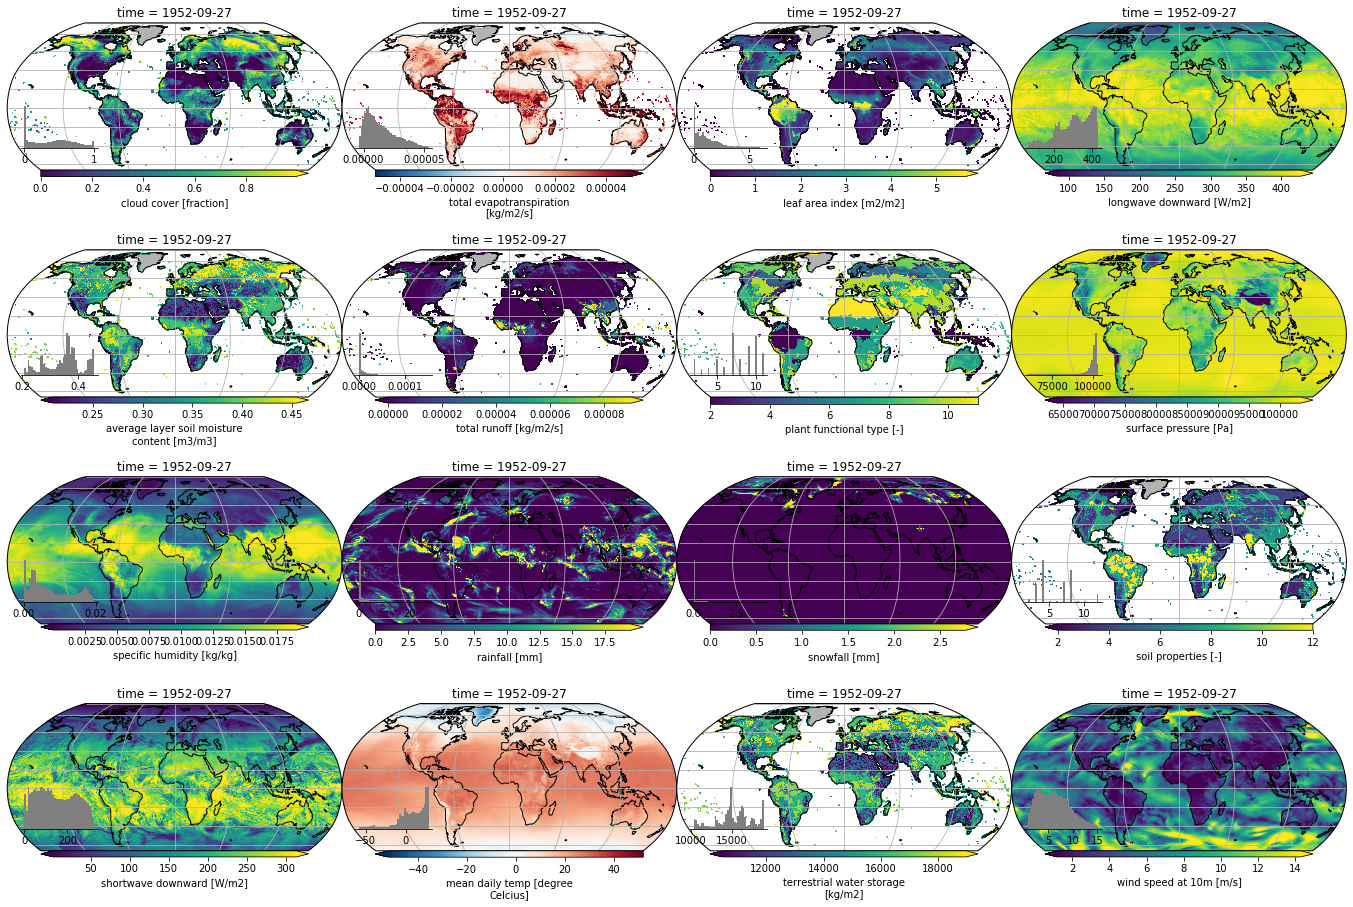

In [266]:
fig, axes = subplots_robinson(4, 4, figsize=(24, 16), gridspec_kw={'wspace': 0, 'hspace': 0.2})
for i, var in enumerate(np.setdiff1d(list(s_xr.data_vars), 'mask')):
    ax = axes.flat[i]
    if 'time' in s_xr[var].dims:
        ds = s_xr[var].isel(time=1000)
    else:
        ds = s_xr[var]

    # ds = (ds - ds.attrs['mean']) / ds.attrs['std']
    plot_map(ds, robust=True, ax=ax)

In [253]:
!du -h --block-size=GB '/scratch/dl_chapter14/data/'

25GB	/scratch/dl_chapter14/data/data.zarr/snowf
25GB	/scratch/dl_chapter14/data/data.zarr/et
1GB	/scratch/dl_chapter14/data/data.zarr/time
1GB	/scratch/dl_chapter14/data/data.zarr/pft
25GB	/scratch/dl_chapter14/data/data.zarr/rainf
25GB	/scratch/dl_chapter14/data/data.zarr/ccover
25GB	/scratch/dl_chapter14/data/data.zarr/qair
25GB	/scratch/dl_chapter14/data/data.zarr/lwdown
1GB	/scratch/dl_chapter14/data/data.zarr/lat
25GB	/scratch/dl_chapter14/data/data.zarr/tair
25GB	/scratch/dl_chapter14/data/data.zarr/wind
1GB	/scratch/dl_chapter14/data/data.zarr/soil_properties
25GB	/scratch/dl_chapter14/data/data.zarr/lai
25GB	/scratch/dl_chapter14/data/data.zarr/mrro
25GB	/scratch/dl_chapter14/data/data.zarr/swdown
25GB	/scratch/dl_chapter14/data/data.zarr/mrlslfrac
25GB	/scratch/dl_chapter14/data/data.zarr/tws
25GB	/scratch/dl_chapter14/data/data.zarr/psurf
1GB	/scratch/dl_chapter14/data/data.zarr/lon
1GB	/scratch/dl_chapter14/data/data.zarr/mask
345GB	/scratch/dl_chapter14/data/data.zarr
1GB	/

# Sandbox

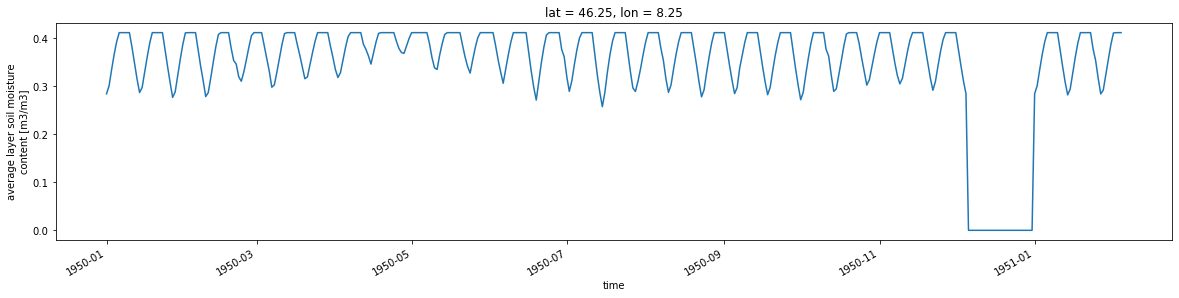

In [289]:
plt.figure(figsize=(20, 4))
s_xr.mrlslfrac.sel(lat=46, lon=8, method='nearest').isel(time=slice(0, 400)).plot()

In [276]:
d = xr.open_dataset('/workspace/BGI/people/skoirala/spmip/full_matsiro-gw_exp3.run1_20180805_latlonReverse/full_matsiro-gw_exp3_experiment_3_1950.nc')
d

<xarray.Dataset>
Dimensions:    (lat: 360, levelc: 13, levelf: 14, lon: 720, time: 366)
Coordinates:
  * lat        (lat) float32 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon        (lon) float32 -179.75 -179.25 -178.75 ... 178.75 179.25 179.75
  * time       (time) datetime64[ns] 1950-01-01 1950-01-02 ... 1951-01-01
  * levelf     (levelf) int32 0 5 25 100 200 300 ... 600 700 800 900 1000 4000
  * levelc     (levelc) int32 5 20 75 100 100 100 100 100 100 100 100 100 3000
Data variables:
    rss        (time, lat, lon) float32 ...
    hfss       (time, lat, lon) float32 ...
    gwrec      (time, lat, lon) float32 ...
    ec         (time, lat, lon) float32 ...
    ts         (time, lat, lon) float32 ...
    hfls       (time, lat, lon) float32 ...
    et         (time, lat, lon) float32 ...
    cw         (time, lat, lon) float32 ...
    es         (time, lat, lon) float32 ...
    tsl        (time, levelc, lat, lon) float32 ...
    hfdss      (time, lat, lon) float32 ...
   

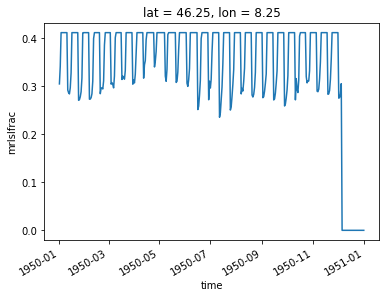

In [293]:
d.mrlslfrac.sel(lat=46, lon=8, method='nearest').isel(time=slice(0, 400), levelc=[3]).mean('levelc').plot()

In [288]:
s_xr.time.values[360:370]

array(['1950-12-27T00:00:00.000000000', '1950-12-28T00:00:00.000000000',
       '1950-12-29T00:00:00.000000000', '1950-12-30T00:00:00.000000000',
       '1950-12-31T00:00:00.000000000', '1951-01-01T00:00:00.000000000',
       '1951-01-02T00:00:00.000000000', '1951-01-03T00:00:00.000000000',
       '1951-01-04T00:00:00.000000000', '1951-01-05T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [77]:
import xarray as xr
import zarr
import numpy as np
import pandas as pd
import torch
from torch.utils.data.dataset import Dataset


class Data(Dataset):
    """Data loader for simulated hydrological data (koirala2017).

    Notes
    ----------
    A mask is used to define valid pixels to sample from. 0 corresponds to non-valid
    pixels (e.g. ocean) and values > 0 are used to defiene spatial sampling locations
    of the cross-validation folds. If 'is_tune' is set to 'True', all pixels where
    mask > 0 are sample locations, but only every 12th pixel in both directions is
    used for training and, shifted by 6 pixels, for validation. If 'is_tune' is 'False',
    all locations where mask == fold are sampled for tesing while all other valid
    locations (mask != 0 & mask != fold) are used for training.

    The temporal partition (defined in the config file) is fixed, 'partition_sets' defines
    whether training or validation period is selected.

    Parameters
    ----------
    config (dict):
        Configuration.
    partition_set (str):
        Cross validation partition set, one of 'train' | 'eval'.
    fold (int):
        The spatial cross-validation fold. Must correspond to values in the mask. -1 means that
        ll data is used. See 'Notes'.
        for more details.
    is_tune (bool):
        If 'True', a subset fo the data will be sampled for tuning of hyperparameters. See
        'Notes' for more details. If 'True', the 'fold' argument has no effect.
    small_aoi: bool
        If True, a subset of the data is used (Europe).
    permute: bool
        Whether to permute the samples, default is False.

    Returns
    ----------
    features_d: nd array
        Dynamic features with shape <time, num_features>
    features_s: nd array
        Static features with shape <1, num_features>
    target: nd array
        Dynamic target with shape <time, 1>
    (lat, lon): tuple of integers
        Latitude and longitude coordinates

    """

    def __init__(
            self,
            config,
            partition_set,
            fold=None,
            is_tune=False,
            small_aoi=False,
            permute=False):

        if partition_set not in ['train', 'eval']:
            raise ValueError(
                f'Argument `partition_set`: Must be one of: [`train` | `eval`].')

        def msg(
            x): return f'Argument ``{x}`` is not an iterable of string elements.'
        if not self._check_striterable(config['input_vars']):
            raise ValueError(msg('input_vars'))
        if not self._check_striterable(config['input_vars_static']):
            raise ValueError(msg('input_vars_static'))
        if not isinstance(config['target_var'], str):
            raise ValueError('Argument ``target_var`` must be a string.')

        self.input_vars = config['input_vars']
        self.input_vars_static = config['input_vars_static']
        self.target_var = config['target_var']

        self.num_inputs = len(self.input_vars) + len(self.input_vars_static)

        self.partition_set = partition_set
        self.fold = fold
        self.is_tune = is_tune
        self.small_aoi = small_aoi
        self.permute = permute if partition_set == 'train' else False

        self.config = config

        ds = xr.open_zarr(self.config['data_path'])
        self.dynamic_vars, self.static_vars = self._get_static_and_dynamic_varnames(
            ds)

        self.time_slicer = TimeSlice(
            ds_path=self.config['data_path'],
            date_range=config['time'][partition_set],
            warmup=config['time']["warmup"],
            partition_set=partition_set,
            train_seq_length=config['time']["train_seq_length"] if partition_set == 'train' else 0)

        self.num_warmup_steps = self.time_slicer.num_warmup

        mask = ds['mask']

        if small_aoi:
            # Set mask outside Europe to 0.
            print('Test run: training on lat > 0 & lon > 0')
            mask = mask.where((mask.lat > 0) & (mask.lon > 0), 0, drop=False)

        # The mask contains 0 for non-valid pixels and integers > 0 for the folds. Here, we get
        # all fold integers.
        folds = np.setdiff1d(np.unique(mask), 0)
        if any(folds < 0):
            raise ValueError(
                f'The mask cannot contain values < 0.')

        # For HP tuning, a subset of the data is used, every 3rd pixel in lat / lon direction.
        if is_tune:

            sparse_grid = self._get_sparse_grid(mask, 3)

            mask = (mask == 1).astype(int)

            mask *= sparse_grid

        # For other model runs, the fold is used for validationg, while all other folds are
        # used for training. E.g. if folds are [1, 2, 3] and fold is 1, the folds [2, 3] are
        # for traiing and 1 for validation.
        else:

            if (fold < -1) or (fold == 0):
                raise ValueError(
                    f'Argument `fold` must be -1 or a value > 0 but is {fold}.')

            if fold not in np.append(folds, -1):
                raise ValueError(
                    f'Fold `{fold}` not found in mask with unique values `{folds}`.')

            # Select all folds.
            if fold == -1:
                mask_select = folds
            else:
                if len(folds) == 1:
                    raise ValueError(
                        f'As the mask contains only one fold ({folds}), you must pass '
                        '``fold=-1`` to make training and valiation both use the same '
                        'fold.'
                    )
                if partition_set == 'train':
                    mask_select = np.setdiff1d(folds, fold)
                else:
                    mask_select = [fold]
                
            mask = mask.isin(mask_select)

        print(mask)
        self.mask = mask
        self.coords = np.argwhere(mask.values)

        self.ds_stats = {
            var: {
                'mean': np.float32(ds[var].attrs['mean']),
                'std': np.float32(ds[var].attrs['std'])
            } for var in ds.data_vars
        }

        self.ds = zarr.open(self.config['data_path'], mode='r')
        self._check_all_vars_present_in_dataset()
        self._check_var_time_dim()

    def __len__(self):
        return self.coords.shape[0]

    def __getitem__(self, inx):
        lat, lon = self.coords[inx]

        t_start, t_end = self.time_slicer.get_time_range()

        # Each single temporal variable has shape <time, lat, lon>. We select one coordinate, yielding
        # shape <time>. All variables are then stacked along last dimension, yielding <time, num_vars>
        features_d = np.stack(
            [self.standardize(self.ds[var][t_start:t_end, lat, lon], var)
             for var in self.input_vars],
            axis=-1
        )

        # Each single non-temporal variable has shape <lat, lon>. We select one coordinate, yielding
        # shape <> (scalar). All variables are then stacked yielding <num_vars> and expanded in the
        # first diension, yielding <1, num_vars>.
        features_s = np.stack(
            [self.standardize(self.ds[var][lat, lon], var)
             for var in self.input_vars_static],
            axis=0
        ).reshape(1, -1)
        features_s = features_s.repeat(features_d.shape[0], axis=0)
        features_d = np.concatenate((features_d, features_s), axis=-1)

        # The (temporal) target variable has shape <time, lat, lon>. We select one coordinate, yielding
        # shape <time>, and expand in the last dimension, yielding <time, 1>.
        target = self.standardize(
            self.ds[self.target_var][t_start:t_end, lat, lon], self.target_var).reshape(-1, 1)

        if np.any(np.isnan(features_d)):
            raise ValueError('NaN in features, training stopped.')

        # Random permute time-series.
        if self.permute:
            perm_indx = torch.randperm(features_d.size(0))
            features_d = features_d[perm_indx, :]
            target = target[perm_indx, :]

        return features_d, target, (lat, lon)

    def get_empty_xr(self):
        ds = xr.open_zarr(self.dyn_target_path)[self.dyn_target_name].isel(
            time=slice(self.t_start + self.num_warmup_steps, self.t_end))

        return ds

    def standardize(self, x, varname):
        return (x - self.ds_stats[varname]['mean']) / self.ds_stats[varname]['std']

    def unstandardize(self, x, varname):
        return x * self.ds_stats[varname]['std'] + self.ds_stats[varname]['mean']

    def _check_striterable(self, x):
        is_iterable_non_str = hasattr(x, '__iter__') & (not isinstance(x, str))
        all_elements_are_str = all([isinstance(x_, str) for x_ in x])
        return is_iterable_non_str & all_elements_are_str

    def _check_all_vars_present_in_dataset(self):
        def msg(
            x): return f'Variable ``{x}`` not found in dataset located at {self.config["path"]}'

        for var in self.input_vars + self.input_vars_static + [self.target_var]:
            if var not in self.ds:
                raise ValueError(msg(var))

    def _check_var_time_dim(self):
        def msg(
            x, y): return f'Variable ``{x}`` seems to be {"non-" if y else ""}temporal, check the variable arguments.'

        for var in self.input_vars + [self.target_var]:
            if self.ds[var].ndim != 3:
                raise ValueError(msg(var, True))
        for var in self.input_vars_static:
            if self.ds[var].ndim != 2:
                raise ValueError(msg(var, False))

    def _get_static_and_dynamic_varnames(self, ds):
        time_vars = []
        non_time_vars = []
        for var in ds.data_vars:
            if 'time' in ds[var].dims:
                time_vars.append(var)
            else:
                non_time_vars.append(var)
        return time_vars, non_time_vars

    def _get_sparse_grid(self, x, gap_size):
        nlat = len(x.lat)
        nlon = len(x.lon)
        r = np.zeros((nlat, nlon), dtype=int)

        for lat in np.arange(0, nlat - 1 - gap_size, gap_size * 2):
            for lon in np.arange(0, nlon - 1 - gap_size, gap_size * 2):
                r[lat, lon] = 1
                r[lat + gap_size, lon + gap_size] = 2

        m = xr.DataArray(r, coords=(x.lat, x.lon))

        return m


class TimeSlice(object):
    """Manage time slicing for training and evaluation set.

    Parameters
    ----------
    ds_path: str
        Path to the data cube (.zarr format).
    data_range: tuple(str, str)
        Date range to read, e.g. ('2000-01-01', '2005-12-31')
    warmup: int
        Number of warmup years that are not used in loss functino. For the training set,
        the warmup period is added **after** the lower time bound, for the evalation set it
        is added **before** the lower time bound, overlapping with the training time-range.
    partition_set: str
        One of ['train' | 'eval']
    train_seq_len: int
        If this is not 0 (default), a sequence of this length will be sampled from the time
        range. the warmup period remains the same, e.g. for a warmup period of one year and
        ``train_seq_len=100``, a time range of warmup + 100 is randomly selected when calling
        ``TimeSlice:get_time_range``.

    """
    def __init__(
            self,
            ds_path,
            date_range,
            warmup,
            partition_set,
            train_seq_length):

        if partition_set not in ['train', 'eval']:
            raise ValueError(
                f'Argument `partition_set`: Must be one of: [`train` | `eval`].')

        self.partition_set = partition_set
        self.do_seq_sample = train_seq_length != 0

        ds_time = xr.open_zarr(ds_path).time
        date_first = pd.to_datetime(ds_time.values[0])
        date_last = pd.to_datetime(ds_time.values[-1])

        seldate_first = pd.to_datetime(date_range[0])
        seldate_last = pd.to_datetime(date_range[1])

        if not (date_first <= seldate_first < date_last):
            raise ValueError(
                f'The selected lower time-series bound ({seldate_first}) '
                f'is not in the dataset time range ({date_first} - {date_last})'
            )
        if not (date_first < seldate_last <= date_last):
            raise ValueError(
                f'The selected upper time-series bound ({seldate_last}) '
                f'is not in the dataset time range ({date_first} - {date_last})'
            )

        warmup_delta = pd.DateOffset(years=warmup)

        # warmup_first is the actual lower limit after applying the warmup period
        # seldate_first is the first date after the warmup period
        if partition_set == 'eval':
            warmup_first = seldate_first - warmup_delta
            if not (date_first <= warmup_first < date_last):
                raise ValueError(
                    f'After applying the warmup period of {warmup} year(s), the lower time-series '
                    f'bound ({warmup_first}) is not in the dataset time range ({date_first} - {date_last}). '
                    f'Note that the warmup period is added before the lower date range in the eval set.'
                )
        else:
            warmup_first = seldate_first
            seldate_first += warmup_delta
            if not (date_first < seldate_first <= date_last):
                raise ValueError(
                    f'After applying the warmup period of {warmup} year(s), the upper time-series '
                    f'bound ({seldate_first}) is not in the dataset time range ({date_first} - {date_last}). '
                    f'Note that the warmup period is added after the lower date range in the train set.'
                )

        self.warmup_first = warmup_first
        self.seldate_first = seldate_first
        self.seldate_last = seldate_last

        date_range = pd.date_range(date_first, date_last)

        self.num_warmup = (seldate_first - warmup_first).days
        self.train_seq_length = self.num_warmup + train_seq_length
        self.start_t = np.argwhere(warmup_first == date_range).item()
        self.end_t = np.argwhere(seldate_last == date_range).item() + 1
        self.seq_len = self.end_t - self.start_t

        if self.seq_len < self.train_seq_length:
            raise ValueError(
                f'The sequence length (train_seq_length ({train_seq_length}) + warmup ({self.num_warmup}) = '
                f' {self.train_seq_length}) is longer than the sequence length ({self.seq_len}).')

        # This is used if train_seq_length > 0 to randomly select a time range of this length from the sequence.
        self.sample_range = range(
            self.start_t, self.end_t - self.train_seq_length)

    def get_time_range(self):
        if not self.do_seq_sample:
            return self.start_t, self.end_t
        else:
            start_t = np.random.choice(self.sample_range)
            end_t = start_t + self.train_seq_length
            return start_t, end_t

    def __repr__(self):
        s = (
            f'TimeSlice object\n\n'
            f'Partition set: {self.partition_set}\n'
            f'Sample lenth: {self.train_seq_length-self.num_warmup if self.do_seq_sample else "full sequence"}d\n\n'
            f'   warmup period: {self.num_warmup:5d}d        sample period: {self.seq_len-self.num_warmup:5d}d\n'
            f'|-------------------------|------------------------------|\n'
            f'|                         |                              | \n'
            f'{self.warmup_first.strftime("%Y-%m-%d")}            '
            f'{self.seldate_first.strftime("%Y-%m-%d")}                '
            f'{self.seldate_last.strftime("%Y-%m-%d")}\n\n'
            f'warmup start: {self.warmup_first.strftime("%Y-%m-%d")}\n'
            f'sample start: {self.seldate_first.strftime("%Y-%m-%d")}\n'
            f'sample end:   {self.seldate_last.strftime("%Y-%m-%d")}\n'

        )
        return s


In [78]:
np.append(np.array([1, 2, 3]), 1)

array([1, 2, 3, 1])

In [79]:
from experiments.hydrology.experiment_config import get_config

In [80]:
config = get_config('default')

In [81]:
d = Data(config, partition_set='train', fold=-1, is_tune=True)

<xarray.DataArray 'mask' (lat: 360, lon: 720)>
dask.array<mul, shape=(360, 720), dtype=int64, chunksize=(90, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8


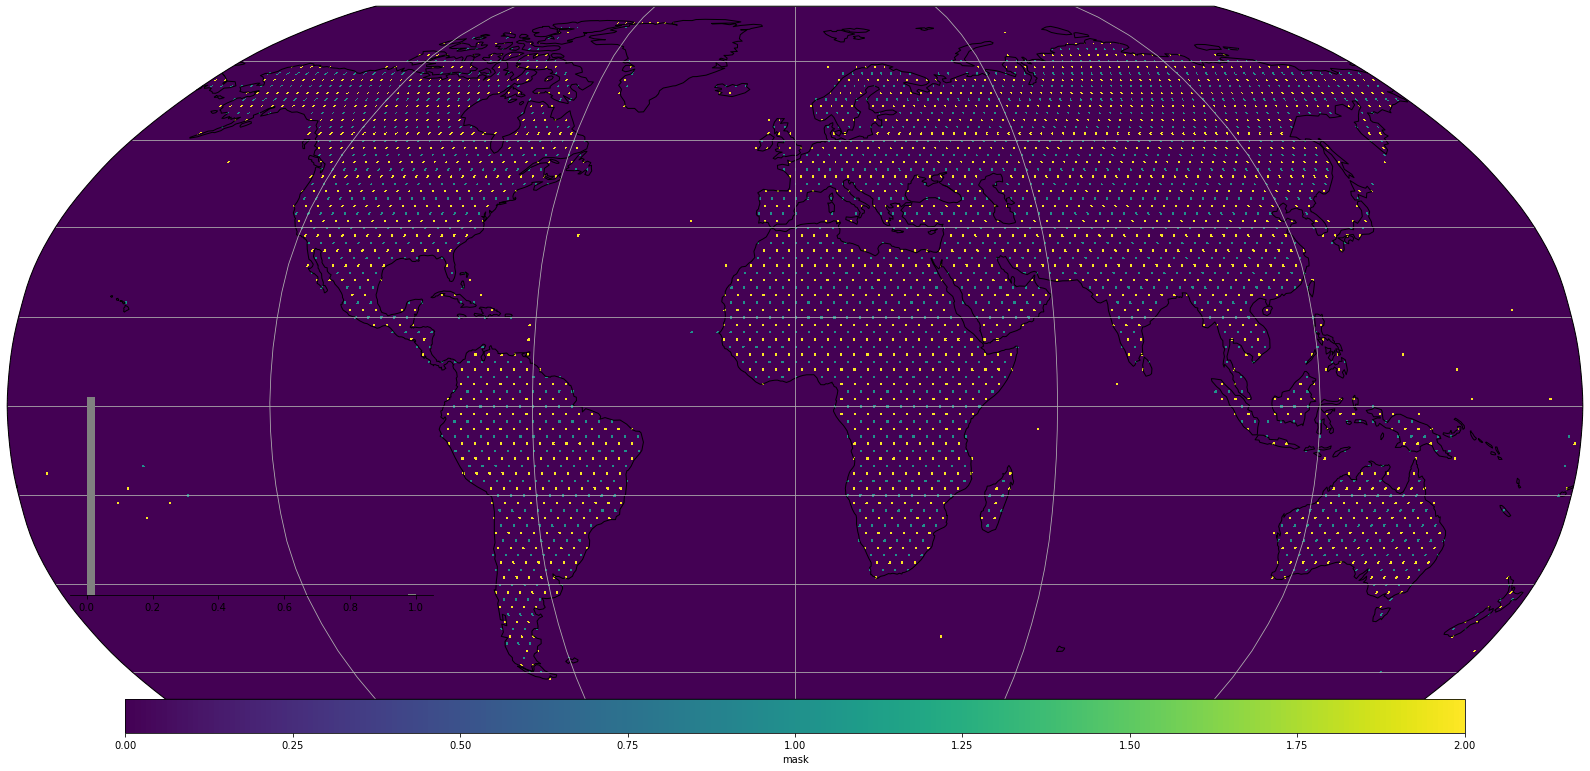

In [82]:
fig, ax = subplots_robinson(figsize=(30, 15))
plot_map(d.mask,ax = ax)

In [32]:
, ax = ax

('ax', '=', 'ax')

In [477]:
d, s, t, (lat, lon) = d[100]

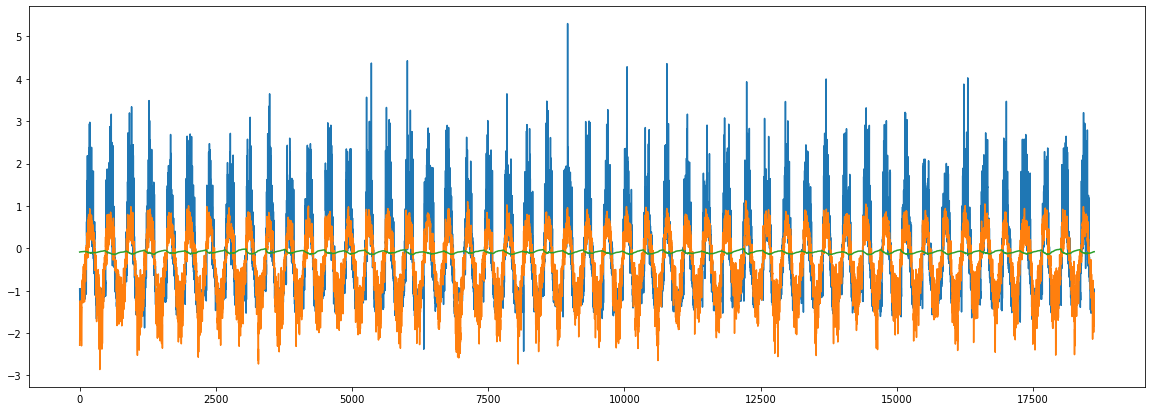

In [467]:
plt.figure(figsize=(20, 7))
plt.plot(d)

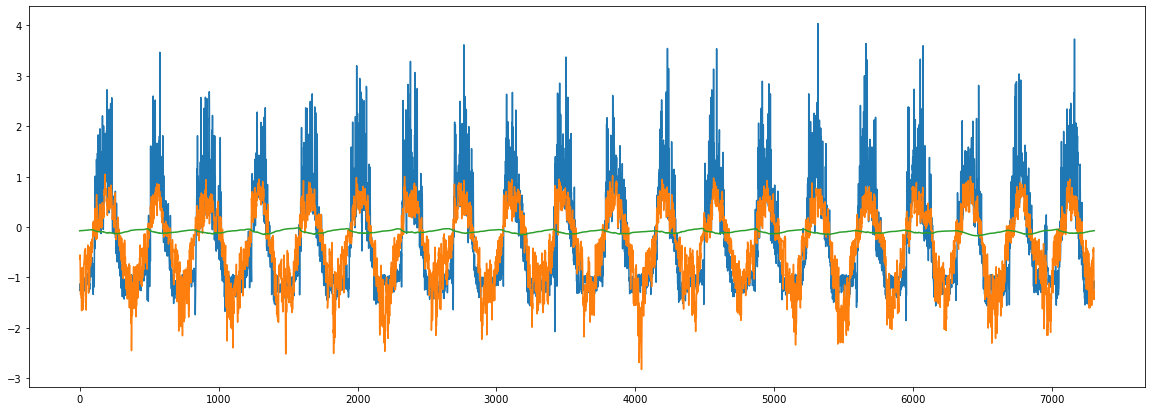

In [470]:
plt.figure(figsize=(20, 7))
plt.plot(d)

In [475]:
d.ds['et']

<zarr.core.Array '/et' (23741, 360, 720) float32 read-only>

In [479]:
d.shape

(7304, 3)

In [ ]:
# Date range, e.g. ['2000-01-01', '2004-12-31']
self.range = config['time']['range']
# Date range, e.g. [2000-01-01, 2000-01-02, ..., 2004-12-31]
self.date_range = pd.date_range(
    self.range[0], self.range[1], freq='1D')

# Date range, e.g. ['2000-01-01', '2002-12-31']
self.part_range = config['time'][partition_set]

# Warmup period in years.
self.num_warmup_years = config['time']["warmup"]

# Sequence length used in training (the entire sequence is too long).
self.train_seq_length = config['time']["train_seq_length"]

# Apply warmup period:
# - if training set: warmup period is added to training period start.
# - if evaludation set: warmup period is subtracted from period start.
if partition_set == 'train':
    warmup_start = self.part_range[0]
    warmup_end = f'{int(self.part_range[0][:4])+self.num_warmup_years}{self.part_range[0][4:]}'
else:
    warmup_start = f'{int(self.part_range[0][:4])-self.num_warmup_years}{self.part_range[0][4:]}'
    warmup_end = self.part_range[0]

# Indices of partition_set (e.g. training) reative to the dataset range.
self.t_start = np.argwhere(self.date_range == warmup_start)[0][0]
self.t_wamup_end = np.argwhere(self.date_range == warmup_end)[0][0]
self.t_end = np.argwhere(self.date_range == self.part_range[1])[0][0]

self.num_warmup_steps = self.t_wamup_end - self.t_start

In [481]:
import pandas as pd

In [484]:
date_range = pd.date_range('2000-01-01', '2001-12-31')
ndays = len(date_range)

# In the training mode, the lower date limit is the first date in date_range.
warmup_start 

731

In [824]:
class TimeSlice(object):
    def __init__(
            self,
            path,
            date_range,
            warmup,
            train_seq_length,
            partition_set):
        
        if partition_set not in ['train', 'eval']:
            raise ValueError(
                f'Argument `partition_set`: Must be one of: [`train` | `eval`].')

        self.partition_set = partition_set
        self.do_seq_sample = train_seq_length != 0

        ds_time = xr.open_zarr("/scratch/dl_chapter14/data/data.zarr/").time
        date_first = pd.to_datetime(ds_time.values[0])
        date_last = pd.to_datetime(ds_time.values[-1])

        seldate_first = pd.to_datetime(date_range[0])
        seldate_last = pd.to_datetime(date_range[1])

        if not (date_first <= seldate_first < date_last):
            raise ValueError(
                f'The selected lower time-series bound ({seldate_first}) '
                f'is not in the dataset time range ({date_first} - {date_last})'
            )
        if not (date_first < seldate_last <= date_last):
            raise ValueError(
                f'The selected upper time-series bound ({seldate_last}) '
                f'is not in the dataset time range ({date_first} - {date_last})'
            )

        warmup_delta = pd.DateOffset(years=warmup)
        
        # warmup_first is the actual lower limit after applying the warmup period
        # seldate_first is the first date after the warmup period
        if partition_set == 'eval':
            warmup_first = seldate_first - warmup_delta
            if not (date_first <= warmup_first < date_last):
                raise ValueError(
                    f'After applying the warmup period of {warmup} year(s), the lower time-series '
                    f'bound ({warmup_first}) is not in the dataset time range ({date_first} - {date_last}). '
                    f'Note that the warmup period is added before the lower date range in the eval set.'
                )
        else:
            warmup_first = seldate_first
            seldate_first += warmup_delta
            if not (date_first < seldate_first <= date_last):
                raise ValueError(
                    f'After applying the warmup period of {warmup} year(s), the upper time-series '
                    f'bound ({seldate_first}) is not in the dataset time range ({date_first} - {date_last}). '
                    f'Note that the warmup period is added after the lower date range in the train set.'
                )

        self.warmup_first = warmup_first
        self.seldate_first = seldate_first
        self.seldate_last = seldate_last

        date_range = pd.date_range(date_first, date_last)

        self.num_warmup = (seldate_first - warmup_first).days
        self.train_seq_length = self.num_warmup + train_seq_length
        self.start_t = np.argwhere(warmup_first==date_range).item()
        self.end_t = np.argwhere(seldate_last==date_range).item() + 1
        self.seq_len = self.end_t - self.start_t

        if self.seq_len < self.train_seq_length:
            raise ValueError(
                f'The sequence length (train_seq_length ({train_seq_length}) + warmup ({self.num_warmup}) = '
                f' {self.train_seq_length}) is longer than the sequence length ({self.seq_len}).')

        # This is used if train_seq_length > 0 to randomly select a time range of this length from the sequence.
        self.sample_range = range(self.start_t, self.end_t - self.train_seq_length)

    def get_time_range(self):
        if not self.do_seq_sample:
            return self.start_t, self.end_t
        else:
            start_t = np.random.choice(self.sample_range)
            end_t = start_t + self.train_seq_length
            return start_t, end_t

    def __repr__(self):
        s = (
            f'TimeSlice object\n\n'
            f'Partition set: {self.partition_set}\n'
            f'Sample lenth: {self.train_seq_length-self.num_warmup if self.do_seq_sample else "full sequence"}d\n\n'
            f'   warmup period: {self.num_warmup:5d}d        sample period: {self.seq_len-self.num_warmup:5d}d\n'
            f'|-------------------------|------------------------------|\n'
            f'|                         |                              | \n'
            f'{self.warmup_first.strftime("%Y-%m-%d")}            '
            f'{self.seldate_first.strftime("%Y-%m-%d")}                '
            f'{self.seldate_last.strftime("%Y-%m-%d")}\n\n'
            f'warmup start: {self.warmup_first.strftime("%Y-%m-%d")}\n'
            f'sample start: {self.seldate_first.strftime("%Y-%m-%d")}\n'
            f'sample end:   {self.seldate_last.strftime("%Y-%m-%d")}\n'
            
        )
        return s


In [825]:
ts = TimeSlice("/scratch/dl_chapter14/data/data.zarr/", ['2000-01-01', '2002-12-31'], warmup=1, train_seq_length=100, partition_set='eval')
ts

TimeSlice object

Partition set: eval
Sample lenth: 100d

   warmup period:   365d        sample period:  1096d
|-------------------------|------------------------------|
|                         |                              | 
1999-01-01            2000-01-01                2002-12-31

warmup start: 1999-01-01
sample start: 2000-01-01
sample end:   2002-12-31

In [752]:
d

<xarray.Dataset>
Dimensions:          (lat: 360, lon: 720, time: 23741)
Coordinates:
  * lat              (lat) float64 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * lon              (lon) float64 -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * time             (time) datetime64[ns] 1950-01-01 1950-01-02 ... 2014-12-31
Data variables:
    ccover           (time, lat, lon) float32 dask.array<chunksize=(23741, 10, 10), meta=np.ndarray>
    et               (time, lat, lon) float32 dask.array<chunksize=(23741, 10, 10), meta=np.ndarray>
    lai              (time, lat, lon) float32 dask.array<chunksize=(23741, 10, 10), meta=np.ndarray>
    lwdown           (time, lat, lon) float32 dask.array<chunksize=(23741, 10, 10), meta=np.ndarray>
    mask             (lat, lon) int64 dask.array<chunksize=(90, 360), meta=np.ndarray>
    mrlslfrac        (time, lat, lon) float32 dask.array<chunksize=(23741, 10, 10), meta=np.ndarray>
    mrro             (time, lat, lon) float32 dask.array<chunksize=(237

In [8]:
dvars = [
    "ccover",
    "lai",
    "lwdown",
    "swdown",
    "psurf",
    "qair",
    "tair",
    "wind",
    "rainf",
    "snowf",
    "et",
    "mrlslfrac",
    "mrro"
]
svars = [
    "soil_properties",
    "pft"
]
target = 'et'

In [2]:
from data.data_loader import Data

In [9]:
data = Data('/workspace/bkraft/dl_chapter14/config/data_loader_config.json', input_vars=dvars, input_vars_static=svars, target_var=target, partition_set='train', is_tune=True)
data.time_slicer

TimeSlice object

Partition set: train
Sample lenth: 2000d

   warmup period:  1826d        sample period: 16802d
|-------------------------|------------------------------|
|                         |                              | 
1950-01-01            1955-01-01                2000-12-31

warmup start: 1950-01-01
sample start: 1955-01-01
sample end:   2000-12-31

In [26]:
%time fd, fs, t, loc = data[0]

CPU times: user 12 ms, sys: 36 ms, total: 48 ms
Wall time: 44.5 ms


In [27]:
from torch.utils.data import DataLoader

In [33]:
dl = DataLoader(data, batch_size=100)

In [37]:
%time fd, fs, t, loc = next(iter(dl))

CPU times: user 568 ms, sys: 2.49 s, total: 3.06 s
Wall time: 3.05 s


In [35]:
fd.shape

torch.Size([100, 3826, 13])

In [13]:
fd.shape

(3826, 13)

In [14]:
fs.shape

(1, 2)

In [10]:
t.shape

(3826, 1)

In [12]:
data.num_warmup_steps

TimeSlice object

Partition set: train
Sample lenth: 2000d

   warmup period:  1826d        sample period: 16802d
|-------------------------|------------------------------|
|                         |                              | 
1950-01-01            1955-01-01                2000-12-31

warmup start: 1950-01-01
sample start: 1955-01-01
sample end:   2000-12-31

In [9]:
s_xr = xr.open_zarr(zarr_store)

In [14]:
s_xr.mask

<xarray.DataArray 'mask' (lat: 360, lon: 720)>
dask.array<zarr, shape=(360, 720), dtype=int64, chunksize=(90, 360), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8

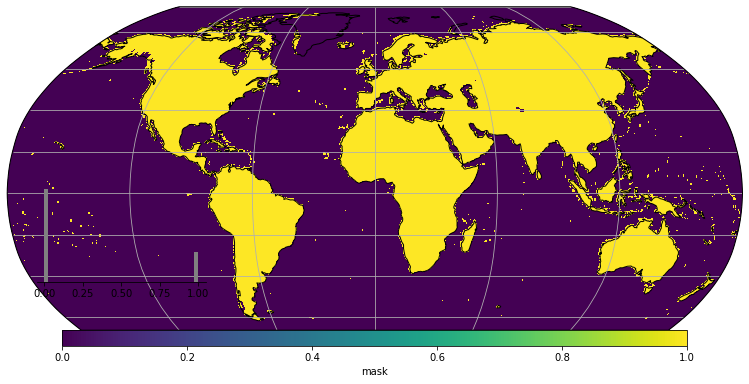

In [5]:
plot_map(s_xr.mask)

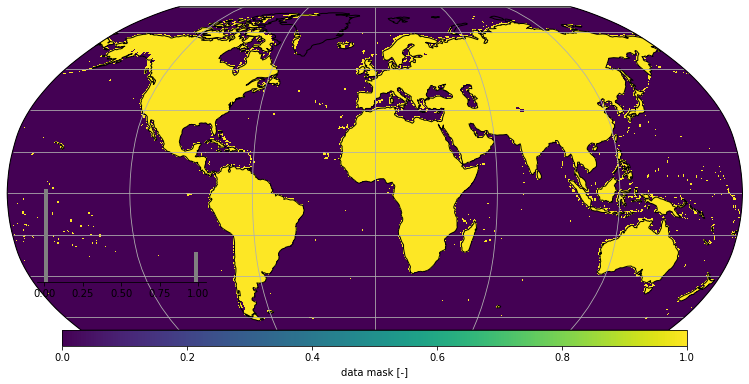

In [90]:
plot_map(s_xr.mask)

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


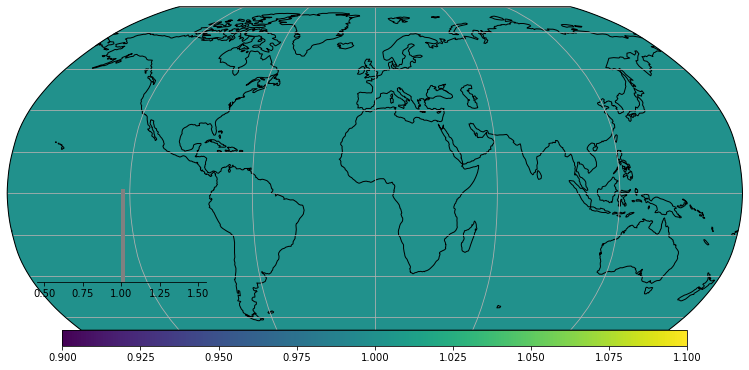

In [95]:
m = s_xr['soil_properties'].notnull()
plot_map(s_xr.mask == m)

In [98]:
m = s_xr['et'].isnull().any('time')

<string>:6: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


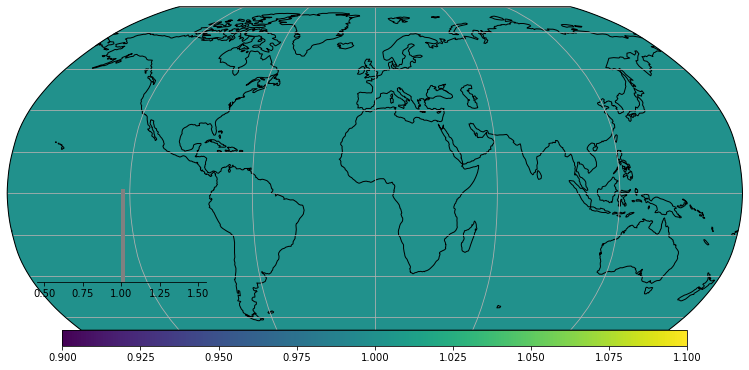

In [97]:
plot_map(s_xr.mask == m)

In [ ]:
mask = s_xr[non_time_vars].to_array().notnull().any('variable').compute()

for var in time_vars:
    print(var)
    mask *= s_xr[var].notnull().any('time').compute()